In [1]:
%matplotlib inline

import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import MESS

from collections import OrderedDict

## Set some pandas options to show the full rows and columns of a DF
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## Where do you want simulations to live?
analysis_dir = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/"


Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-MESS-client.json


## Figure 3 - Summaries of distributions through time
![Figure3 Cartoon](files/Fig3-mockup.png "MESS Figure 3 Cartoon")

In [ ]:
## Run in a shell: ipcluster start -n 40 --cluster-id=MESS --daemonize
try:
    ipyclient = ipp.Client(cluster_id="MESS")
    print(len(ipyclient))
except:
    pass

## Generate simulations for figure 3
Here we fix all parameters except speciation rate and community assembly model. Generate 1000 simulations for each of the configurations (hi, lo, no speciation) and (neut, filt, comp) assembly.

In [ ]:
r = MESS.Region("figure3")
## Region params
r.set_param("project_dir", analysis_dir)
r.set_param("generations", 0)
r.set_param("mutation_rate", 2.2e-8)
r.set_param("alpha", 2000)
r.set_param("community_assembly_model", "*")

## Metacommunity Params
r.set_param("S_m", 250)
r.set_param("J_m", 750000)
r.set_param("speciation_rate", 2)
r.set_param("death_proportion", 0.7)
r.set_param("trait_rate_meta", 2)
r.set_param("ecological_strength", 1)

## Local Params
r.set_param("J", 1000)
r.set_param("m", 0.005)

for sp_prob in [0, 0.0005, 0.005]:
    r.set_param("speciation_prob", sp_prob)
    r.write_params(outfile="params-fig3-sp{}.txt".format(sp_prob), force=True)
    r.run(sims=1000, ipyclient=ipyclient)

    Generating 1000 simulation(s).
  [################### ]  99%  Performing Simulations    | 1:40:55 | 
    Cancelling remaining simulations.
  [####################] 100% 
    Finished 1000 simulations
     Generating 1000 simulation(s).


## Generate the figure

In [9]:
simfile_01 = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_0.01-J_2000/SIMOUT.txt"
simfile_1 = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_1-J_1000/SIMOUT.txt"
simfile_5 = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_5-J_2000/SIMOUT.txt"

sim_df = pd.read_csv(simfile_01, sep="\t", header=0)

## Remove degenerate trait hill sims
sim_df = sim_df[sim_df["S"] >= sim_df["trait_h1"]]
## Drop sims that are exactly _lambda == 1
sim_df = sim_df[sim_df["_lambda"] < 1]

comp_df = sim_df[sim_df["community_assembly_model"] == "competition"]
filt_df = sim_df[sim_df["community_assembly_model"] == "filtering"]
neut_df = sim_df[sim_df["community_assembly_model"] == "neutral"]
print(len(neut_df), len(filt_df), len(comp_df))

(984, 867, 931)


In [47]:
stat_dict = OrderedDict({})
stat_dict["Richness"] = ["S"]
stat_dict["Abundance Diversity"] = ["abund_h1", "abund_h2", "abund_h3", "abund_h4"]
stat_dict["Genetic Diversity"] = ["pi_h1", "pi_h2", "pi_h3", "pi_h4"]
stat_dict["Trait Diversity"] = ["trait_h1", "trait_h2", "trait_h3", "trait_h4"]

def plot_sumstats_through_time(sim_df, scatter=True, normalize_hills=False):
    ## Get min and max y values so the y values can be scaled identically w/in columns
    def min_max(df, stat):
        return min(df[stat]), max(df[stat])
    ylims = {x:min_max(sim_df, stat_dict[x][0]) for x in stat_dict.keys()}

    fig, axs = plt.subplots(3, 4, figsize=(20, 10))

    for i, (spec_label, spec_prob) in enumerate(zip(["High", "Low", "No"], [0.005, 0.0005, 0])):
        x = sim_df.loc[sim_df["speciation_prob"] == spec_prob]["_lambda"]
        #import pdb; pdb.set_trace()
        for j, sumstats in enumerate(stat_dict):
            for stat in stat_dict[sumstats]:
                y = sim_df.loc[sim_df["speciation_prob"] == spec_prob]
                ## Plotting
                if normalize_hills and not stat == "S":
                    y = y[stat]/y["S"]
                else:
                    y = y[stat]
                z = np.poly1d(np.polyfit(x,y,4))
                xs_z = np.linspace(0, max(x), 1000)
                if scatter: axs[i][j].scatter(x, y, alpha=0.2, marker='.')
                axs[i][j].plot(xs_z, z(xs_z), label=stat, lw=3)

                ## Labeling and cleaning up the plots
                axs[i][j].set_title(sumstats)
                axs[i][j].set_ylabel(spec_label)
                axs[i][j].set_ylim(ylims[sumstats])
    plt.tight_layout()


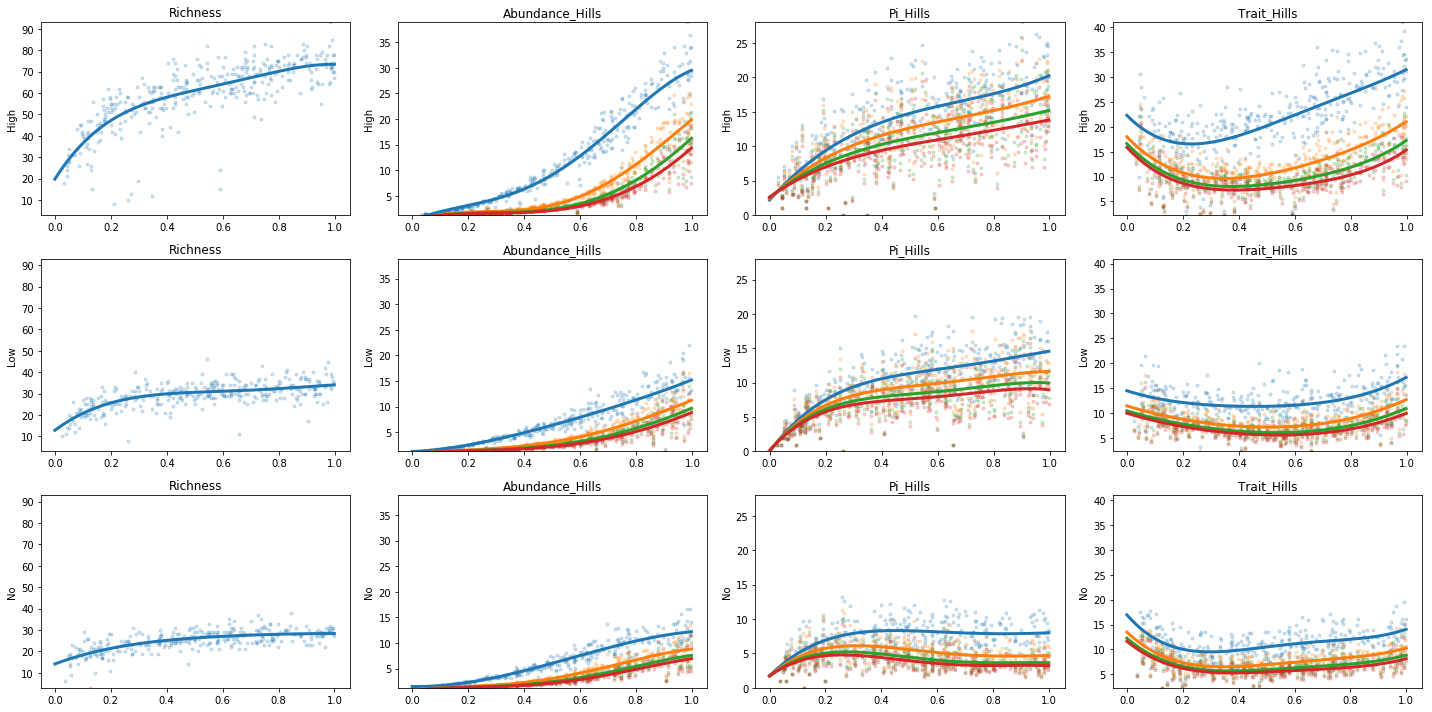

In [11]:
plot_sumstats_through_time(neut_df, scatter=True, normalize_hills=False)

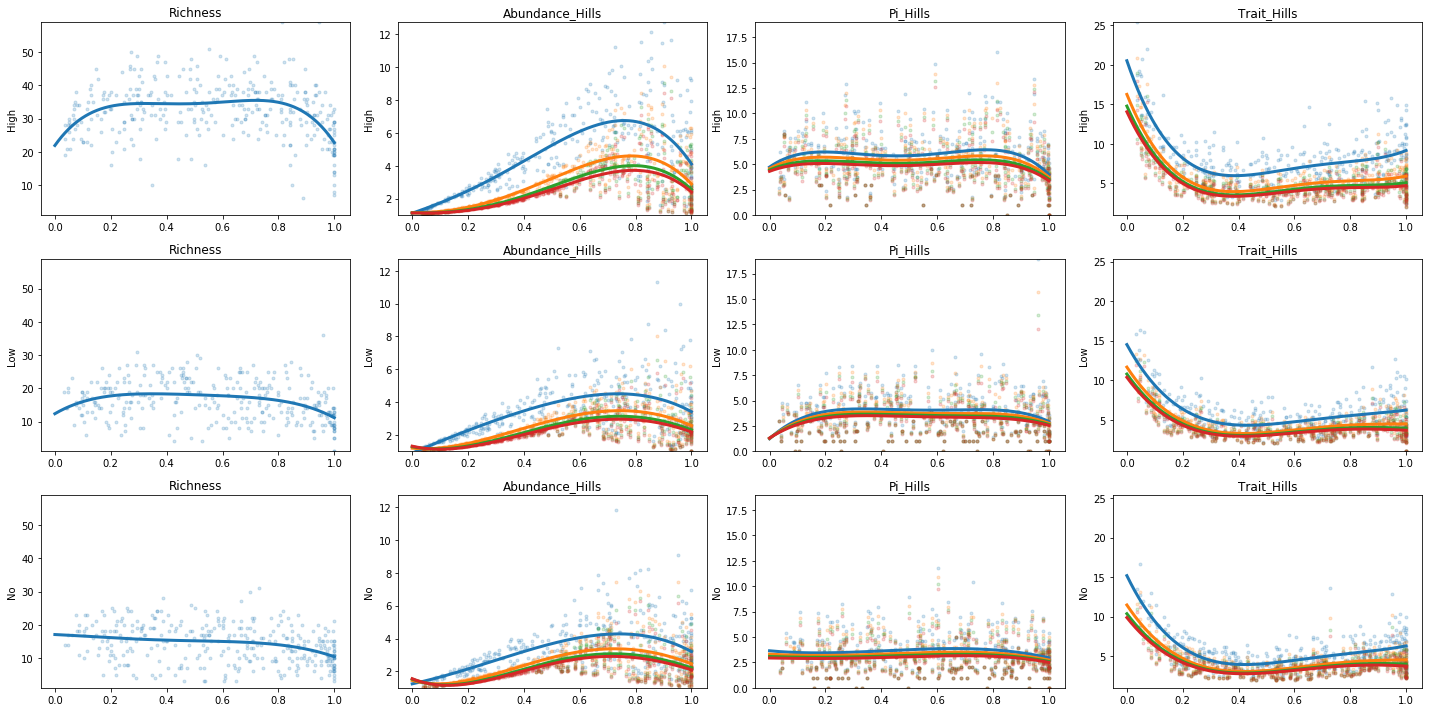

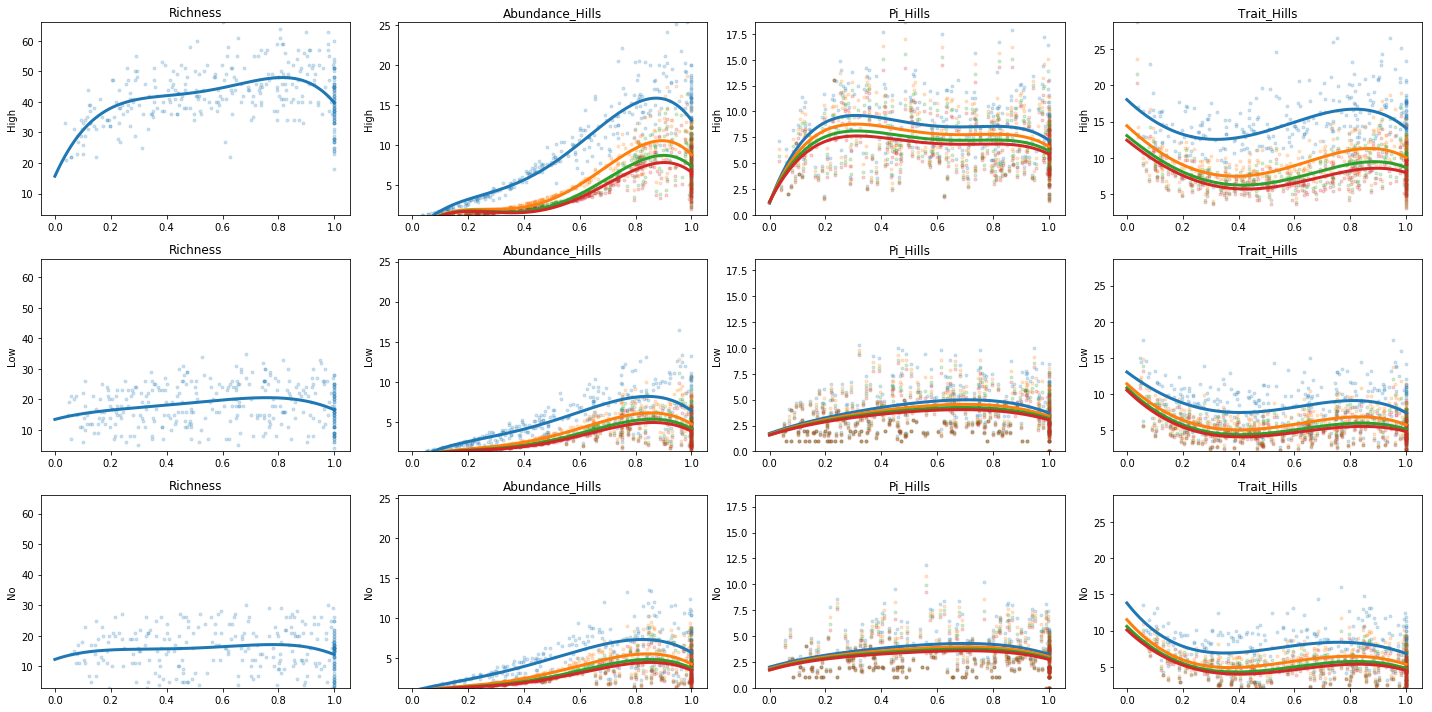

In [140]:
plot_sumstats_through_time(filt_df, scatter=True, normalize_hills=False)
plot_sumstats_through_time(comp_df, scatter=True, normalize_hills=False)

# Manuscript Figure 3. Plot all assembly models on one figure.


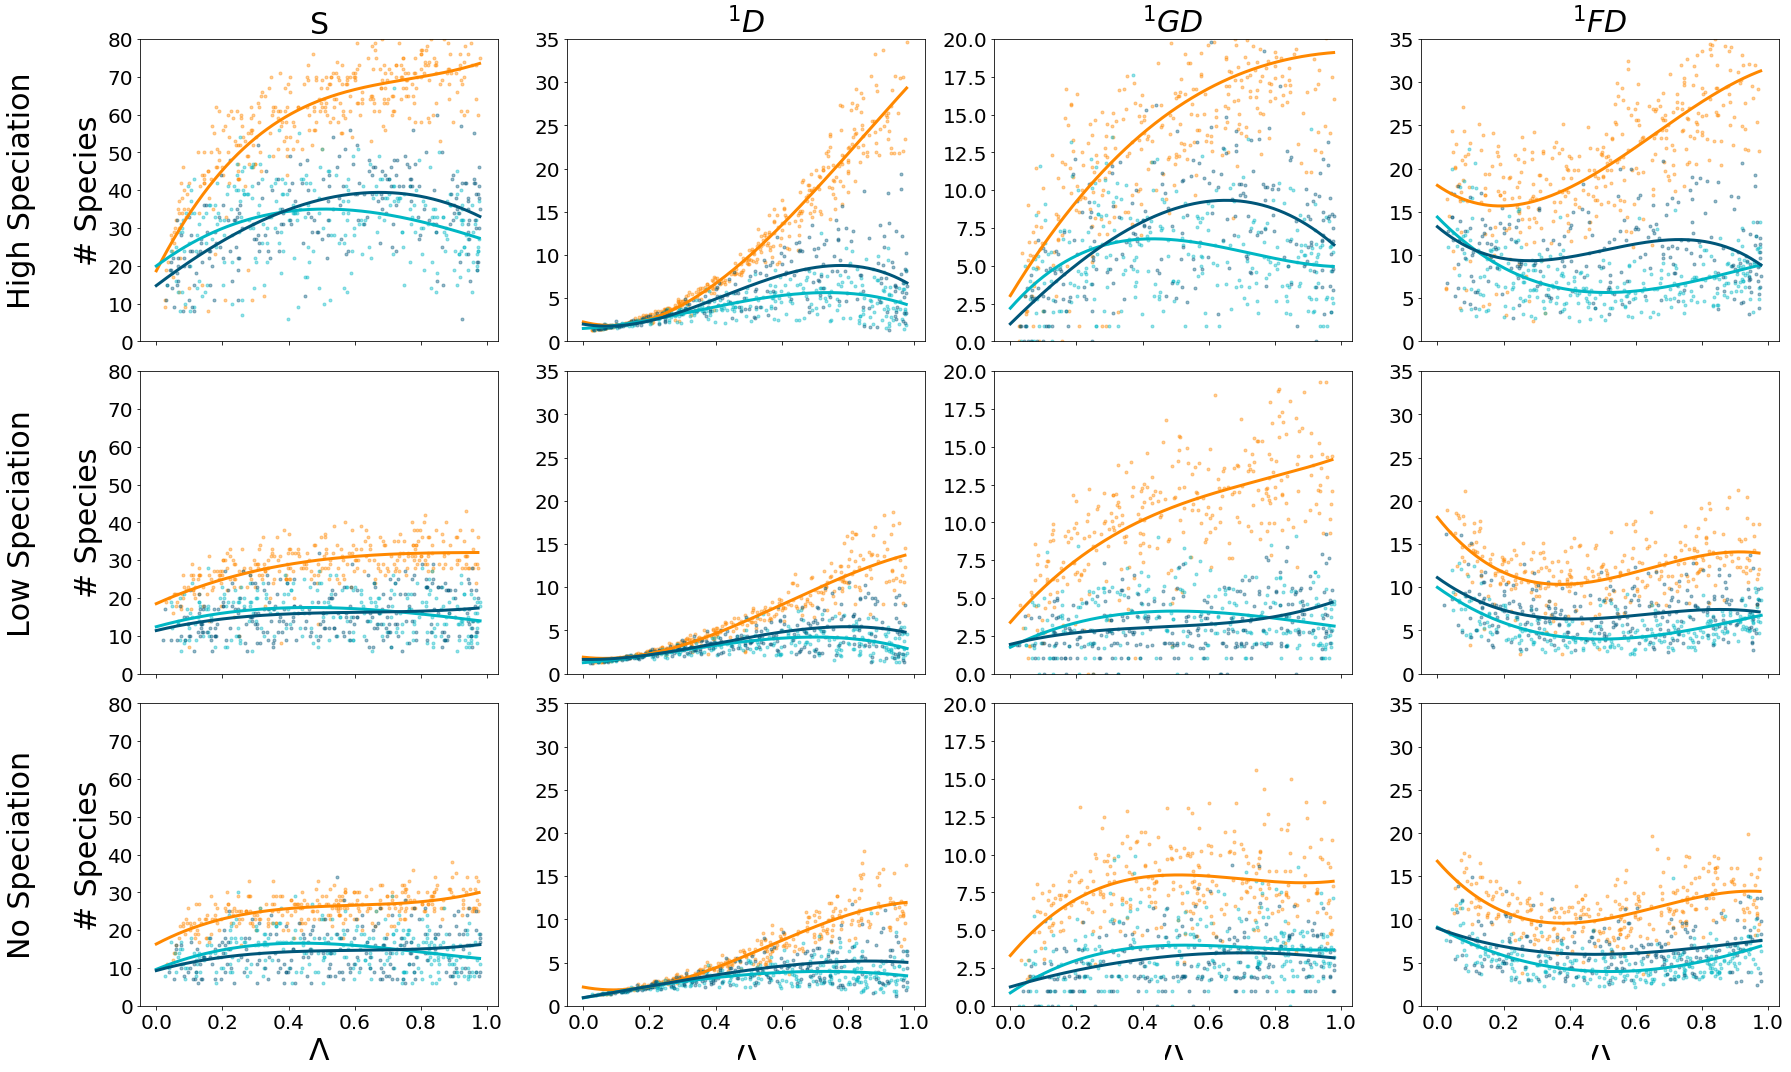

In [83]:

def plot_combined_sumstats_through_time(sim_df, scatter=True, normalize_hills=False, n_hills=2, degree=4):
    ## Get min and max y values so the y values can be scaled identically w/in columns
    def min_max(df, stat):
        return min(df[stat]), max(df[stat])
    ylims = {x:min_max(sim_df, stat_dict[x][0]) for x in stat_dict.keys()}
    ## Hax
    ylims = {"Richness":(0,80), "Abundance Diversity":(0,35), "Genetic Diversity":(0,20), "Trait Diversity":(0,35)}
    plot_labels = {"Richness":"S", "Abundance Diversity":r"$^\mathit{1}D$",\
                   "Genetic Diversity":r"$^\mathit{1}GD$", "Trait Diversity":r"$^\mathit{1}FD$"}
    if normalize_hills: ylims = {"Richness":(0,85), "Abundance Diversity":(0,0.6),\
                                 "Genetic Diversity":(0,0.6), "Trait Diversity":(0.1,1)}

    fig, axs = plt.subplots(3, 4, figsize=(25, 15), sharey=False, sharex=True)

    for i, (spec_label, spec_prob) in enumerate(zip(["High Speciation", "Low Speciation", "No Speciation"], [0.005, 0.0005, 0])):
        
        for j, sumstats in enumerate(stat_dict):
            for stat in stat_dict[sumstats][:n_hills]:
                for model, ls, c in zip(["neutral", "filtering", "competition"],\
                                     #["solid", "dashed", "dotted"],
                                     ["solid", "solid", "solid"],
                                     MESS.plotting.model_colors.values()):
                    
                    x = sim_df.loc[sim_df["community_assembly_model"] == model]
                    x = x.loc[x["speciation_prob"] == spec_prob]["_lambda"]
                    y = sim_df.loc[sim_df["community_assembly_model"] == model]
                    y = y.loc[y["speciation_prob"] == spec_prob]
                    
                    ## Plotting
                    if normalize_hills and not stat == "S":
                        y = y[stat]/y["S"]
                    else:
                        y = y[stat]
                    z = np.poly1d(np.polyfit(x,y,degree))
                    xs_z = np.linspace(0, max(x), 1000)
                    if scatter: axs[i][j].scatter(x, y, alpha=0.4, marker='.', c=c)
                    axs[i][j].plot(xs_z, z(xs_z), label=stat, lw=3, ls=ls, c=c)

                    ## Labeling and cleaning up the plots
                    if i % 4 == 0:
                        axs[i][j].set_title(plot_labels[sumstats], fontsize=30)
                    if i == 2:
                        axs[i][j].set_xlabel(u"Λ", fontsize=30)
                    if j % 4 == 0:
                        axs[i][j].set_ylabel("{}\n\n{}".format(spec_label, "# Species"), fontsize=30)
                    axs[i][j].set_ylim(ylims[sumstats])

    ## Make axis ticklabels easier to read
    [plt.setp(ax.get_xticklabels(), fontsize=20) for ax in axs.flatten()]
    [plt.setp(ax.get_yticklabels(), fontsize=20) for ax in axs.flatten()]
    
    plt.tight_layout()
    #plt.savefig(analysis_dir + "fig3-combined.png")
plot_combined_sumstats_through_time(sim_df, scatter=True, normalize_hills=False, n_hills=1, degree=3)

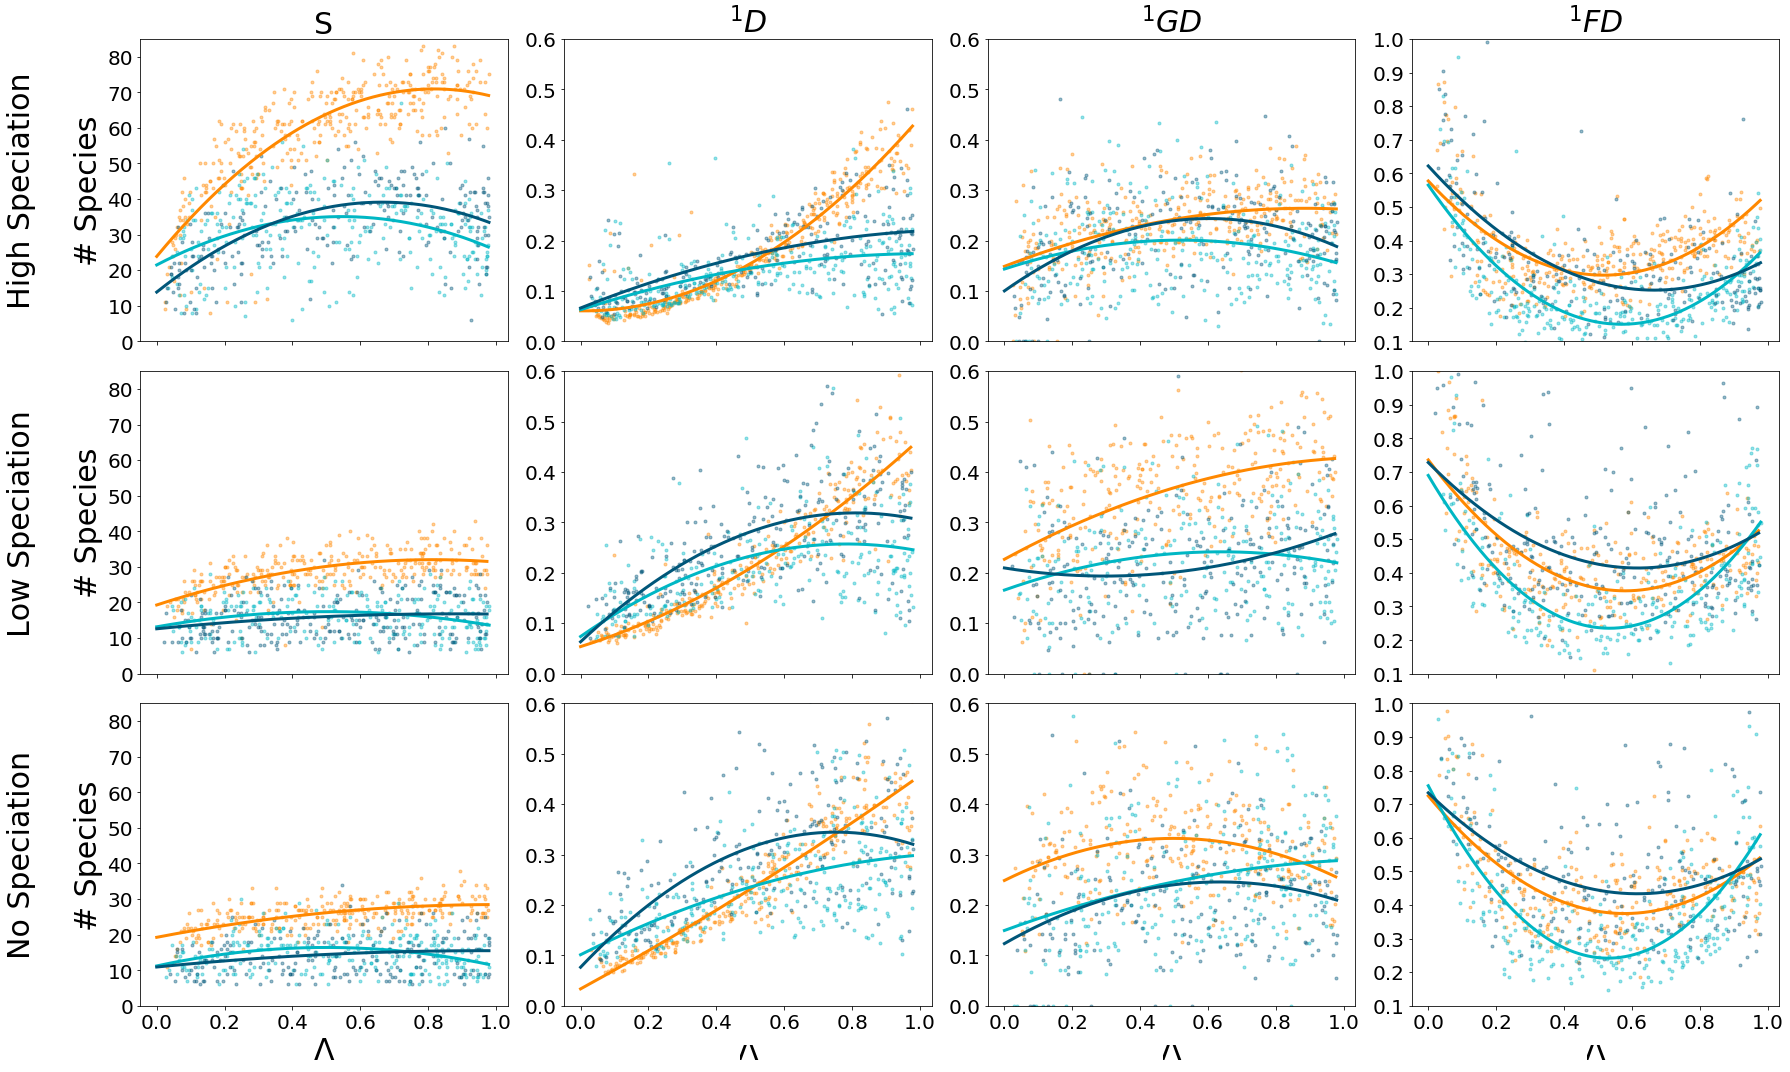

In [85]:
plot_combined_sumstats_through_time(sim_df, scatter=True, normalize_hills=True, n_hills=1, degree=2)

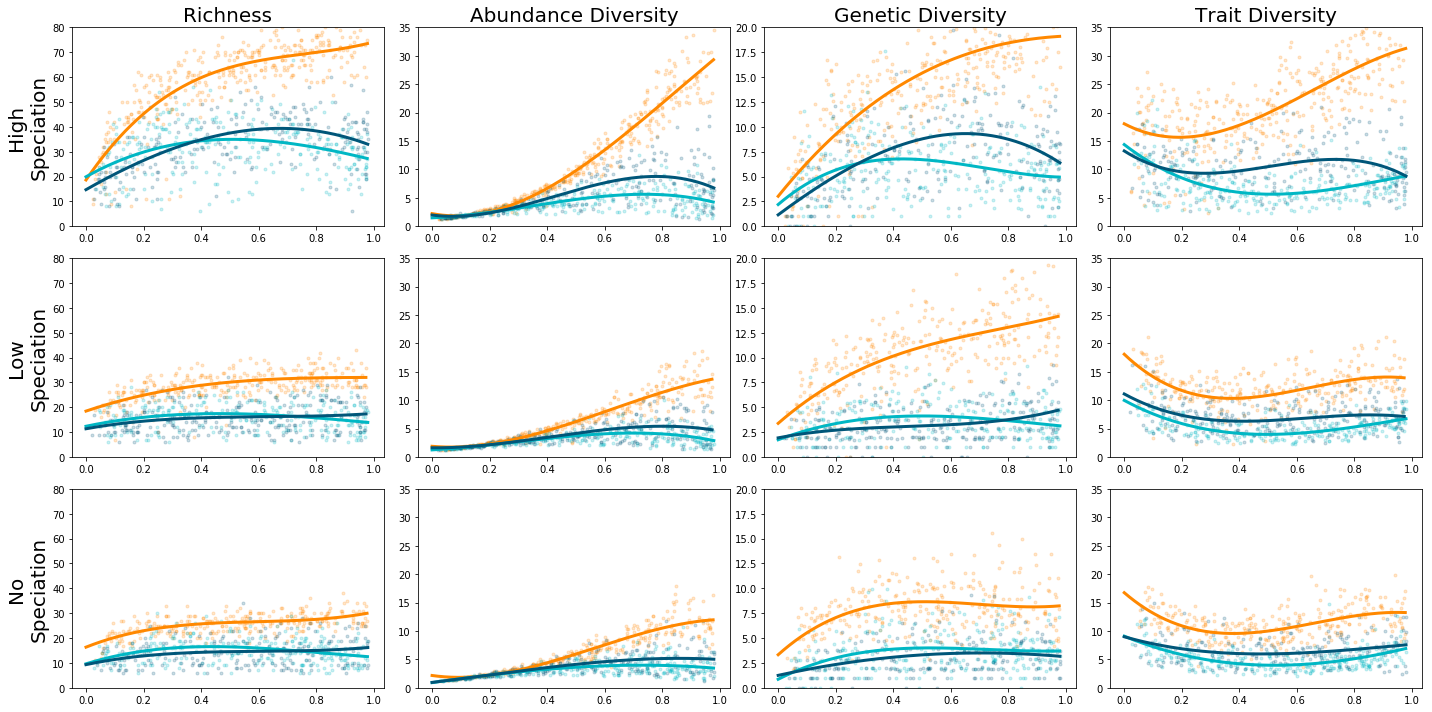

In [55]:
simfile_01 = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_0.01-J_2000/SIMOUT.txt"
simfile_1 = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_1-J_1000/SIMOUT.txt"
simfile_5 = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_5-J_2000/SIMOUT.txt"

sim_df = pd.read_csv(simfile_5, sep="\t", header=0)

sim_df = sim_df[sim_df["S"] > 5]

## Remove degenerate trait hill sims
sim_df = sim_df[sim_df["S"] >= sim_df["trait_h1"]]
## Drop sims that are exactly _lambda == 1
sim_df = sim_df[sim_df["_lambda"] < 0.98]
plot_combined_sumstats_through_time(sim_df, scatter=True, normalize_hills=False, n_hills=1, degree=3)

## Prototyping

In [72]:
[x for x in sim_df.columns if "cor" in x]

['abundance_dxy_cor',
 'abundance_pi_cor',
 'abundance_trait_cor',
 'dxy_pi_cor',
 'dxy_trait_cor',
 'pi_trait_cor']

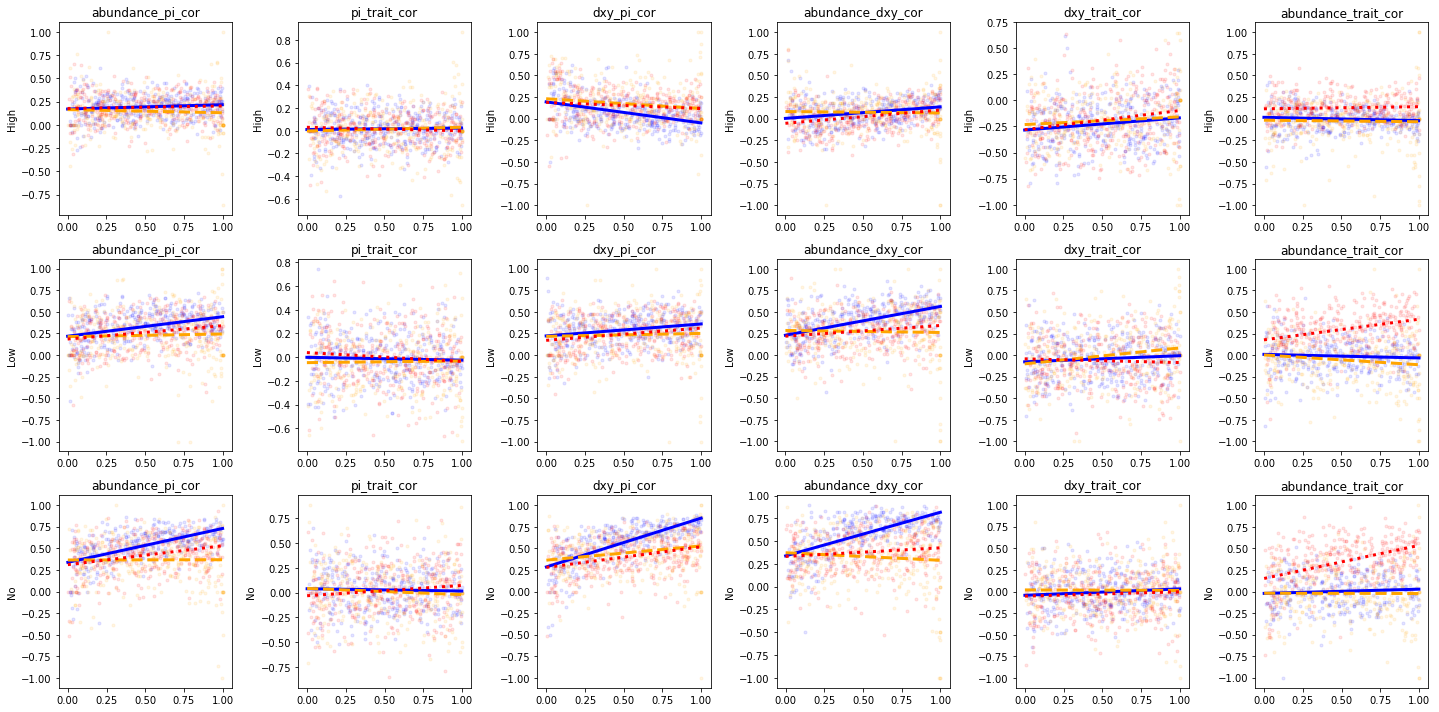

In [8]:
cors = ["abundance_pi_cor", "pi_trait_cor", "dxy_pi_cor",\
"abundance_dxy_cor", "dxy_trait_cor", "abundance_trait_cor"]

def plot_correlations_through_time(sim_df, scatter=True, degree=1):
    ## Get min and max y values so the y values can be scaled identically w/in columns


    fig, axs = plt.subplots(3, 6, figsize=(20, 10))

    for i, (spec_label, spec_prob) in enumerate(zip(["High", "Low", "No"], [0.005, 0.0005, 0])):

        for j, cor in enumerate(cors):
            for model, ls, c in zip(["neutral", "filtering", "competition"],\
                                 ["solid", "dashed", "dotted"],
                                 ["blue", "orange", "red"]):
                x = sim_df.loc[sim_df["community_assembly_model"] == model]
                x = x.loc[x["speciation_prob"] == spec_prob]["_lambda"]
                y = sim_df.loc[sim_df["community_assembly_model"] == model]
                y = y.loc[y["speciation_prob"] == spec_prob][cor]

                z = np.poly1d(np.polyfit(x,y,degree))
                xs_z = np.linspace(0, max(x), 1000)
                if scatter: axs[i][j].scatter(x, y, alpha=0.1, marker='.', c=c)
                axs[i][j].plot(xs_z, z(xs_z), label=model, lw=3, ls=ls, c=c)

                ## Labeling and cleaning up the plots
                axs[i][j].set_title(cor)
                axs[i][j].set_ylabel(spec_label)
    plt.tight_layout()
plot_correlations_through_time(tmp_df, scatter=True)

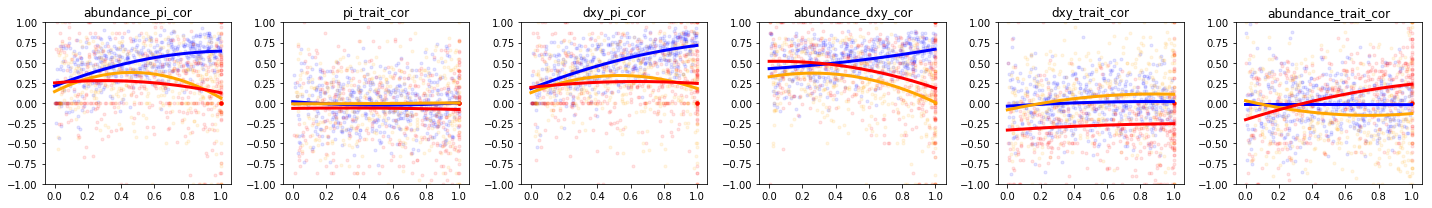

In [300]:
f = "/home/iovercast/Continuosity/MESS/MESS/default_MESS/es_0.001-SIMOUT.txt"
f = "/home/iovercast/Continuosity/MESS/MESS/default_MESS/es_1-SIMOUT.txt"
#f = "/home/iovercast/Continuosity/MESS/MESS/default_MESS/SIMOUT.txt"

#f = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_0.01-J_2000/SIMOUT.txt"
#f = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_1-J_1000/SIMOUT.txt"
#f = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_5-J_2000/SIMOUT.txt"

sim_df = pd.read_csv(f, sep="\t", header=0)
fig, axs = plt.subplots(1, 6, figsize=(20, 3))
for j, cor in enumerate(cors):
    scatter=True
    for model, ls, c in zip(["neutral", "filtering", "competition"],\
                         #["solid", "dashed", "dotted"],
                         ["solid", "solid", "solid"],
                         ["blue", "orange", "red"]):
        x = sim_df.loc[sim_df["community_assembly_model"] == model]
        #x = x["generation"]
        x = x["_lambda"]
        
        y = sim_df.loc[sim_df["community_assembly_model"] == model]
        y = y[cor]

        degree = 2
        z = np.poly1d(np.polyfit(x,y,degree))
        xs_z = np.linspace(0, max(x), 1000)
        if scatter: axs[j].scatter(x, y, alpha=0.1, marker='.', c=c)
        axs[j].plot(xs_z, z(xs_z), label=model, lw=3, ls=ls, c=c)

        ## Labeling and cleaning up the plots
        axs[j].set_title(cor)
        axs[j].set_ylim(-1, 1)
        #axs[j].set_ylabel("No speciation")
#plt.legend()
plt.tight_layout()

In [7]:
simfile_01 = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_0.01-J_2000/SIMOUT.txt"
simfile_1 = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_1-J_1000/SIMOUT.txt"
simfile_5 = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_5-J_2000/SIMOUT.txt"
for f in [simfile_01, simfile_1, simfile_5]:
    tmp_df = pd.read_csv(f, sep="\t", header=0)
    plot_correlations_through_time(tmp_df, scatter=True)

NameError: name 'plot_correlations_through_time' is not defined

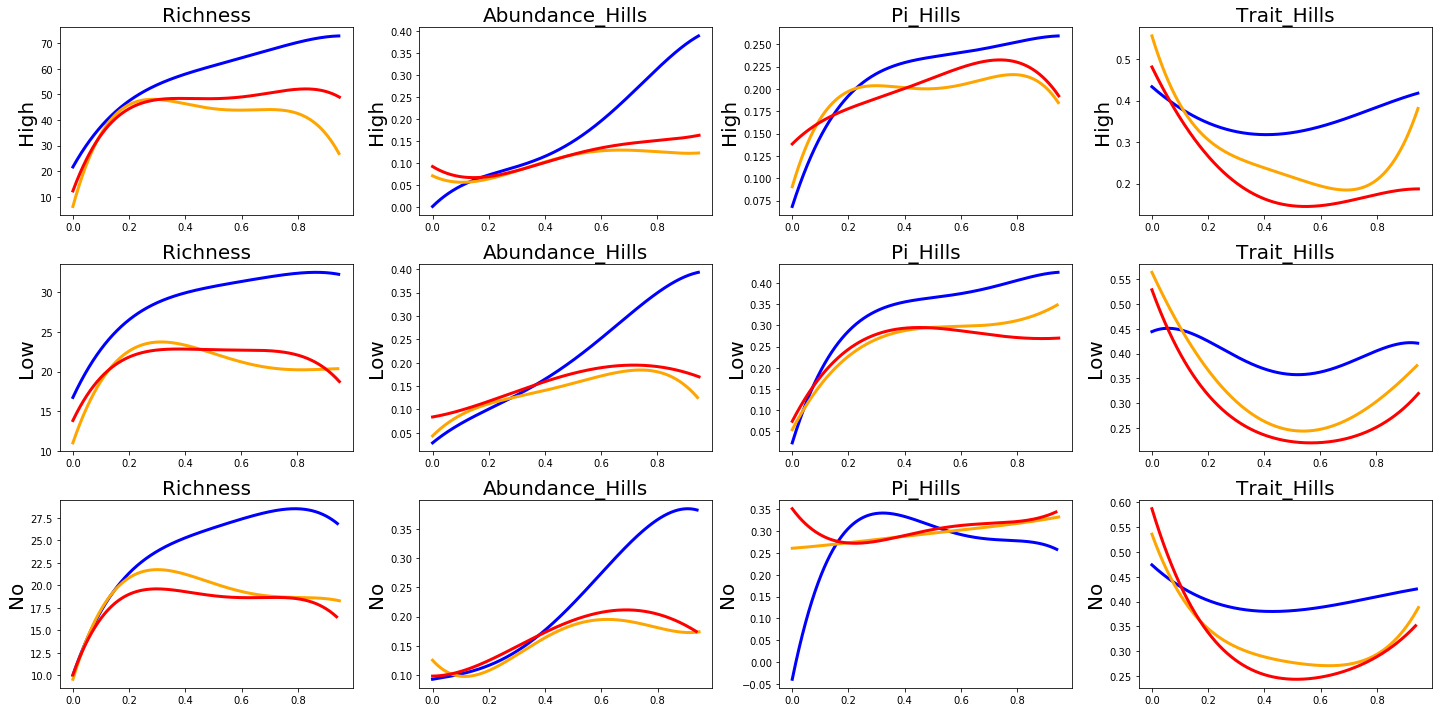

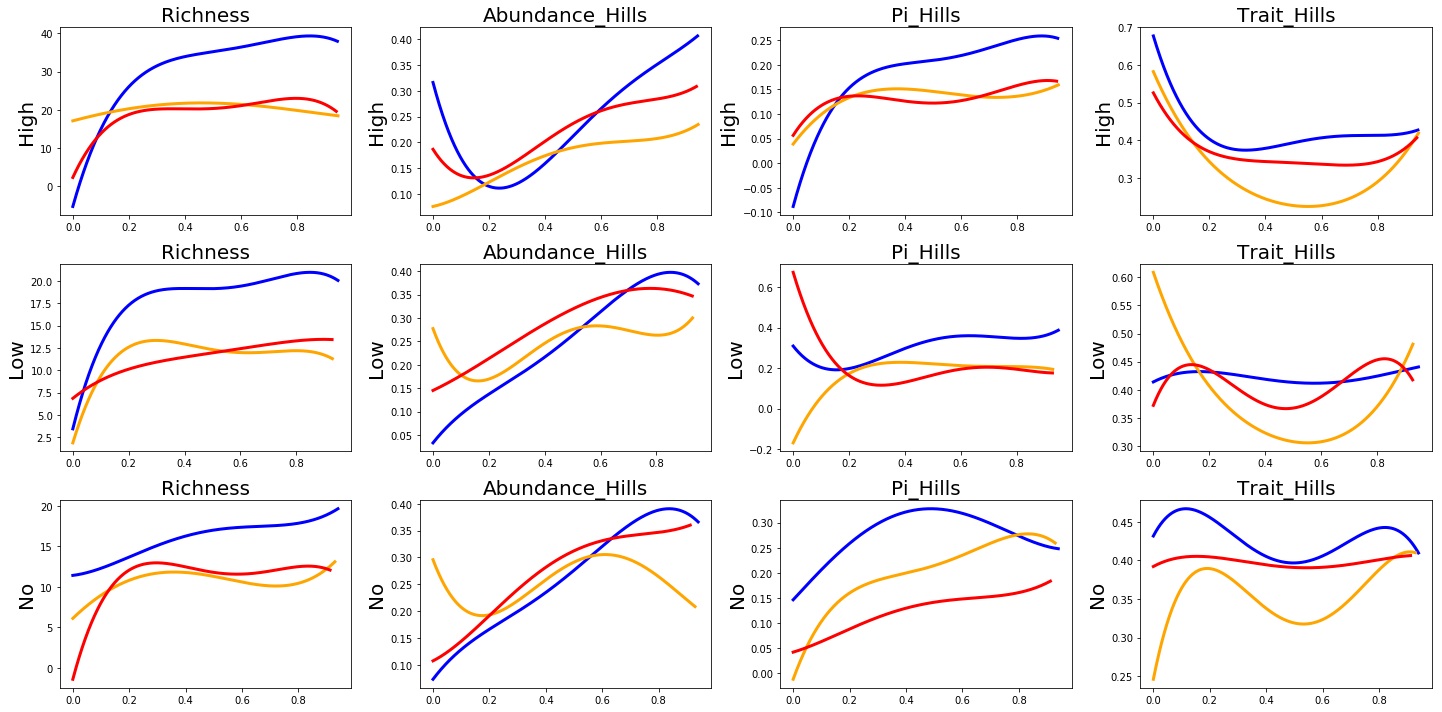

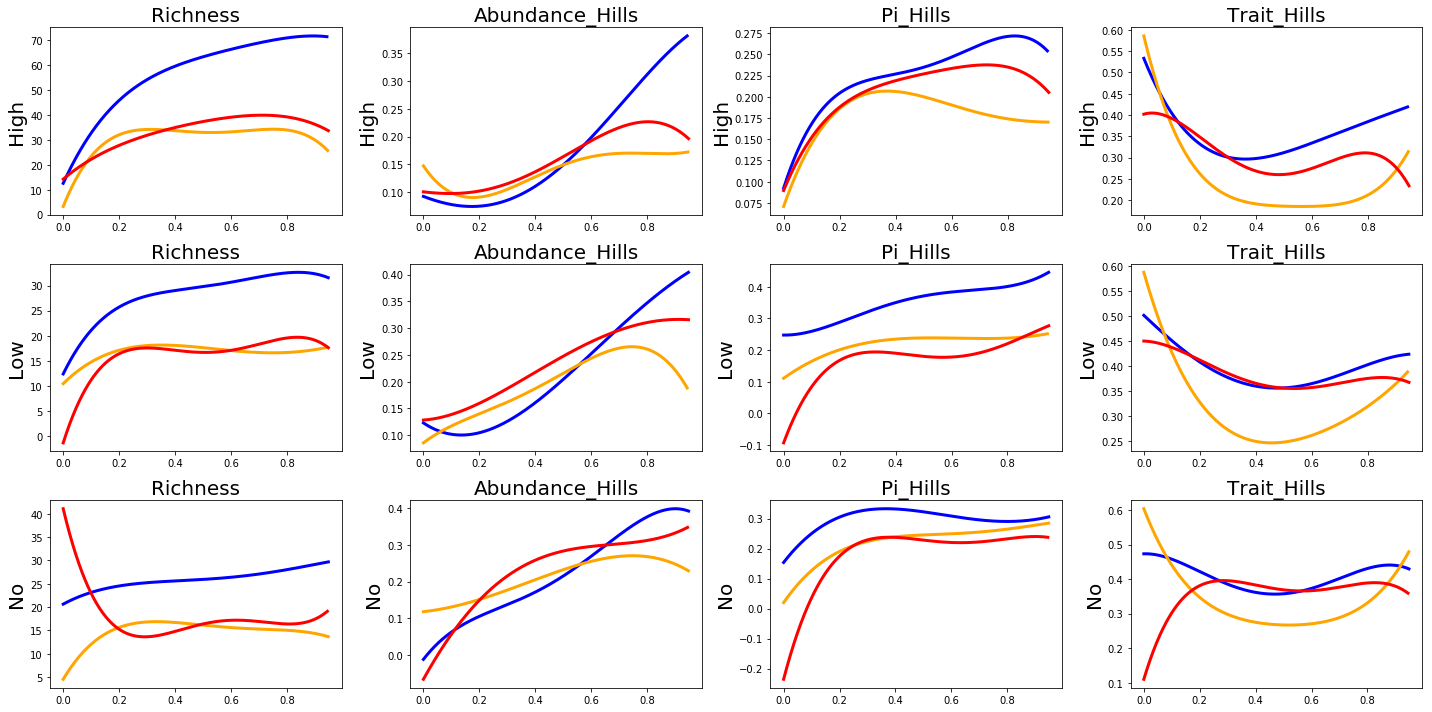

In [301]:
simfile_01 = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_0.01-J_2000/SIMOUT.txt"
simfile_1 = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_1-J_1000/SIMOUT.txt"
simfile_5 = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_5-J_2000/SIMOUT.txt"
for f in [simfile_01, simfile_1, simfile_5]:
    tmp_df = pd.read_csv(f, sep="\t", header=0)
    ## Remove degenerate trait hill sims
    tmp_df = tmp_df[tmp_df["S"]/2. >= tmp_df["trait_h1"]]
    ## Drop sims that are exactly _lambda == 1
    tmp_df = tmp_df[tmp_df["_lambda"] < 0.95]

    #plot_combined_sumstats_through_time(tmp_df, scatter=False, normalize_hills=False, n_hills=1)
    plot_combined_sumstats_through_time(tmp_df, scatter=False, normalize_hills=True, n_hills=1, degree=4)

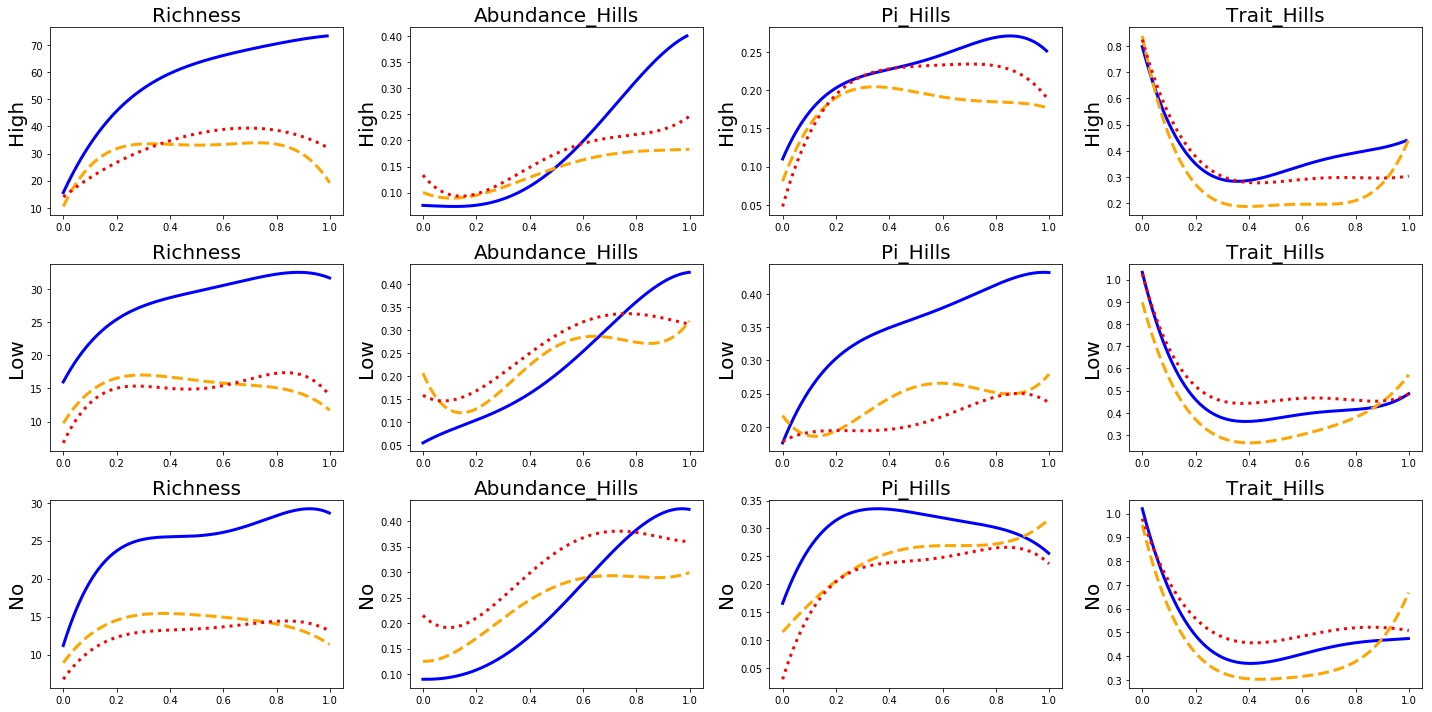

In [265]:
f = "/home/iovercast/Continuosity/MESS/analysis/figure3-sims/es_5-J_2000/SIMOUT.txt"
tmp_df = pd.read_csv(f, sep="\t", header=0)
## Remove degenerate trait hill sims
tmp_df = tmp_df[tmp_df["S"] >= tmp_df["trait_h1"]]
## Drop sims that are exactly _lambda == 1
tmp_df = tmp_df[tmp_df["_lambda"] < 1]

#plot_combined_sumstats_through_time(tmp_df, scatter=False, normalize_hills=False, n_hills=1)
plot_combined_sumstats_through_time(tmp_df, scatter=False, normalize_hills=True, n_hills=1)

In [2]:
!hostname

goatzilla
